In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

Grammer Checking Model using Sample Data

Epoch 1/10, Train Loss: 0.6920900399034674, Test Loss: 0.6986947547305714
Epoch 2/10, Train Loss: 0.6898987889289856, Test Loss: 0.7007848024368286
Epoch 3/10, Train Loss: 0.6877559965307062, Test Loss: 0.7028922005133196
Epoch 4/10, Train Loss: 0.6856140277602456, Test Loss: 0.7050118500536139
Early stopping at epoch 4 as test loss hasn't improved in 3 epochs.


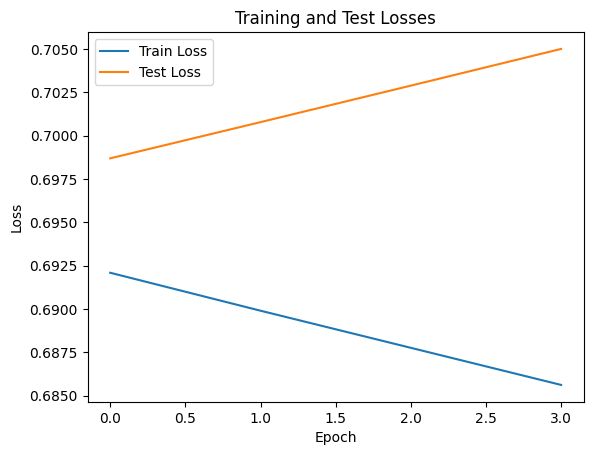

In [17]:
# Sample data
train_data = [
    ("I goes to the store everyday.", "I go to the store everyday."),
    ("They was playing soccer last night.", "They were playing soccer last night."),
    ("She have completed her homework.", "She has completed her homework."),
    ("He don't know the answer.", "He doesn't know the answer."),
    ("The sun rise in the east.", "The sun rises in the east."),
    ("I am eat pizza for lunch.", "I am eating pizza for lunch."),
    ("The students studies for the exam.", "The students study for the exam."),
    ("The car need to be repaired.", "The car needs to be repaired."),
    ("She will goes to the party tonight.", "She will go to the party tonight."),
    ("They watches the movie together.", "They watch the movie together."),
    ("The flowers is blooming in spring.", "The flowers bloom in spring.")
]

test_data = [
    ("I went to the store yesterday.", "I go to the store everyday."),
    ("They were playing soccer last night.", "They were playing soccer last night."),
    ("She has completed her homework.", "She has completed her homework."),
    ("He doesn't know the answer.", "He doesn't know the answer."),
    ("The sun rises in the east.", "The sun rises in the east."),
    ("I am eating pizza for lunch.", "I am eating pizza for lunch."),
    ("The students study for the exam.", "The students study for the exam."),
    ("The car needs to be repaired.", "The car needs to be repaired."),
    ("She will go to the party tonight.", "She will go to the party tonight."),
    ("They watch the movie together.", "They watch the movie together."),
    ("The flowers bloom in spring.", "The flowers bloom in spring.")
]

# Tokenize the sentences
def tokenize(sentence):
    return sentence.lower().split()

# Vocabulary
vocab = set()
for correct_sent, incorrect_sent in train_data + test_data:  # Include both train and test data
    vocab.update(tokenize(correct_sent))
    vocab.update(tokenize(incorrect_sent))
word2index = {word: idx for idx, word in enumerate(vocab)}
index2word = {idx: word for word, idx in word2index.items()}
vocab_size = len(vocab)

# Convert sentences to tensors
def sentence_to_tensor(sentence):
    tokenized = tokenize(sentence)
    tensor = torch.zeros(len(tokenized), dtype=torch.long)
    for i, word in enumerate(tokenized):
        tensor[i] = word2index[word]
    return tensor

# Creating Model
class GrammarChecker(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(GrammarChecker, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 2)  # 2 for binary classification

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.rnn(embedded)
        output = self.fc(output[:, -1, :])  # Take the last output of the sequence
        return output

#Trained model and added early stopping to solve overfitting issue
def train(model, optimizer, criterion, num_epochs=10, early_stopping_patience=3):
    train_losses = []
    test_losses = []
    best_test_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        total_loss = 0
        for correct_sent, incorrect_sent in train_data:
            correct_tensor = sentence_to_tensor(correct_sent).unsqueeze(0)
            incorrect_tensor = sentence_to_tensor(incorrect_sent).unsqueeze(0)
            target = torch.tensor([0]) if correct_sent == incorrect_sent else torch.tensor([1])  # 0 for correct, 1 for incorrect

            optimizer.zero_grad()
            output = model(correct_tensor)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        train_losses.append(total_loss / len(train_data))
        test_loss = evaluate(model, criterion, test_data)
        test_losses.append(test_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]}, Test Loss: {test_losses[-1]}")

        if test_loss < best_test_loss:
            best_test_loss = test_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= early_stopping_patience:
            print(f"Early stopping at epoch {epoch+1} as test loss hasn't improved in {early_stopping_patience} epochs.")
            break  # Stop training

    return train_losses, test_losses

# Evaluation
def evaluate(model, criterion, data):
    total_loss = 0
    with torch.no_grad():
        for correct_sent, _ in data:
            correct_tensor = sentence_to_tensor(correct_sent).unsqueeze(0)
            output = model(correct_tensor)
            target = torch.tensor([0])  # We assume all sentences are correct for testing
            loss = criterion(output, target)
            total_loss += loss.item()
    return total_loss / len(data)

# Instantiate the model
embedding_dim = 5
hidden_dim = 3
model = GrammarChecker(vocab_size, embedding_dim, hidden_dim)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Train the model
train_losses, test_losses = train(model, optimizer, criterion, num_epochs=10)

# Visualize the training/test losses
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Losses')
plt.legend()
plt.show()
